In [2]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import interpolate
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_curve, auc

from importlib import reload

import MODULES
from MODULES import preprocess_dict
from MODULES import metrics_utils
from MODULES.surv_sampling import sampling_index, get_sets_from_index
from MODULES.uq import sorted_patients, calculate_group_errs, calculate_c_index, \
    cal_acceptable_rate, decide_warning
from MODULES.surv_utils import cal_time_bin_index
from MODULES.pe_functions import position_encoding

from decimal import Decimal

def create_display_number(xx):
    if xx < 1e-2:
        return '%.2E'%Decimal(xx)
    else:
        return str(round(xx, 2))


In [63]:
def get_fprs_tprs(permutation_path, ind):
    df_uq = pd.read_csv(f'{permutation_path}{ind}/df_uq.csv', index_col=0)
    label = df_uq['event_at_time_t'].values
    y_score = df_uq['hazard_pred_at_time_t'].values
    fpr_wo_uq, tpr_wo_uq, thresholds = roc_curve(label, y_score)
    auc_wo_uq = auc(fpr_wo_uq, tpr_wo_uq)
    ## get fpr tpr with UQ
    ## warning pred
    x = thresholds
    x = pd.unique(x)
    x = sorted(x)

    ## warning uq
    y = sorted(df_uq['uq_score'].unique()) 
    y.insert(0, 0) if y[0]>0 else None
    y.insert(len(y), 1) if y[-1]<1 else None

    X, Y = np.meshgrid(x, y)
    Z = [z for z in map(lambda x,y: cal_acceptable_rate(
        df_uq, x, y, 'event_at_time_t', 'hazard_pred_at_time_t'), X.flatten(), Y.flatten())]
    fprs = np.array([z['FPR'] for z in Z]).reshape(X.shape)
    tprs = np.array([z['TPR'] for z in Z]).reshape(X.shape)

    fprs = np.insert(fprs, fprs.shape[1], 0, axis=1)
    tprs = np.insert(tprs, tprs.shape[1], 0, axis=1)

    auc_values = [auc(fprs[i], tprs[i]) for i in range(fprs.shape[0])]
    max_ind = auc_values.index(max(auc_values))
    auc_w_uq = auc_values[max_ind]
    fpr_w_uq = fprs[max_ind]
    tpr_w_uq = tprs[max_ind]
    
    return fpr_wo_uq, tpr_wo_uq, auc_wo_uq,\
        fpr_w_uq, tpr_w_uq, auc_w_uq


def interp_uq(axis_list):
    x = set()
    for axis in axis_list: 
        x = x.union( set(axis[:,0]))
    x = list(x)
    x.sort()
    
    ys = []
    for axis in axis_list:
        f = interpolate.interp1d(axis[:,0], axis[:,1])
        ys.append(f(x))
    ys = np.array(ys).reshape(len(ys), -1)
    return x, np.mean(ys, axis=0)

In [64]:
result_path = 'results/'
permutation_num = 1000
inds = ['radiomics_only', 'PE_0', 'PE_0d5', 'PE1_0', 'PE_2d0', 'LungRADS']
cols = ['c-index', 'ibs', 'AUC', 'AUC_based-ACC', 'AUC_based-FPR', 'AUC_based-FNR']


ind = 'PE1_0'

# # Try to load existing collections, otherwise initialize empty lists
# try:
#     rad_info_collection = list(np.load(f'{result_path}rad_info_collection.npy', allow_pickle=True))
#     auc_wo_uq_collection = list(np.load(f'{result_path}auc_wo_uq_collection.npy', allow_pickle=True))
#     auc_w_uq_collection = list(np.load(f'{result_path}auc_w_uq_collection.npy', allow_pickle=True))
#     fpr_wo_uq_collection = list(np.load(f'{result_path}fpr_wo_uq_collection.npy', allow_pickle=True))
#     fpr_w_uq_collection = list(np.load(f'{result_path}fpr_w_uq_collection.npy', allow_pickle=True))
#     tpr_wo_uq_collection = list(np.load(f'{result_path}tpr_wo_uq_collection.npy', allow_pickle=True))
#     tpr_w_uq_collection = list(np.load(f'{result_path}tpr_w_uq_collection.npy', allow_pickle=True))
# except:
#     rad_info_collection = []
#     auc_wo_uq_collection = []
#     auc_w_uq_collection = []
#     fpr_wo_uq_collection = []
#     fpr_w_uq_collection = []
#     tpr_wo_uq_collection = []
#     tpr_w_uq_collection = []
    
# for permutation in tqdm(range(permutation_num)):
#     permutation_path = result_path+str(permutation)+'/'
#     df_stats = pd.read_csv(permutation_path+'stats.csv', index_col=0)
#     rad_info_collection += list(df_stats.loc['LungRADS'].dropna().values)
#     fpr_wo_uq, tpr_wo_uq, auc_wo_uq, fpr_w_uq,\
#         tpr_w_uq, auc_w_uq = get_fprs_tprs(permutation_path, ind)
#     auc_wo_uq_collection.append(auc_wo_uq)
#     auc_w_uq_collection.append(auc_w_uq)
#     fpr_wo_uq_collection.append(fpr_wo_uq)
#     fpr_w_uq_collection.append(fpr_w_uq)
#     tpr_wo_uq_collection.append(tpr_wo_uq)
#     tpr_w_uq_collection.append(tpr_w_uq)   
# rad_info_collection = np.array(rad_info_collection).reshape(-1, 4)

# # Save all collections
# np.save(f'{result_path}rad_info_collection.npy', rad_info_collection)
# np.save(f'{result_path}auc_wo_uq_collection.npy', auc_wo_uq_collection)
# np.save(f'{result_path}auc_w_uq_collection.npy', auc_w_uq_collection)
# np.save(f'{result_path}fpr_wo_uq_collection.npy', fpr_wo_uq_collection)
# np.save(f'{result_path}fpr_w_uq_collection.npy', fpr_w_uq_collection)
# np.save(f'{result_path}tpr_wo_uq_collection.npy', tpr_wo_uq_collection)
# np.save(f'{result_path}tpr_w_uq_collection.npy', tpr_w_uq_collection)

In [65]:
rad_info_collection = list(np.load(f'{result_path}rad_info_collection.npy', allow_pickle=True))
auc_wo_uq_collection = list(np.load(f'{result_path}auc_wo_uq_collection.npy', allow_pickle=True))
auc_w_uq_collection = list(np.load(f'{result_path}auc_w_uq_collection.npy', allow_pickle=True))
fpr_wo_uq_collection = list(np.load(f'{result_path}fpr_wo_uq_collection.npy', allow_pickle=True))
fpr_w_uq_collection = list(np.load(f'{result_path}fpr_w_uq_collection.npy', allow_pickle=True))
tpr_wo_uq_collection = list(np.load(f'{result_path}tpr_wo_uq_collection.npy', allow_pickle=True))
tpr_w_uq_collection = list(np.load(f'{result_path}tpr_w_uq_collection.npy', allow_pickle=True))

In [80]:
def get_fprs_tprs(permutation_path, ind):
    df_uq = pd.read_csv(f'{permutation_path}{ind}/df_uq.csv', index_col=0)
    label = df_uq['event_at_time_t'].values
    y_score = df_uq['hazard_pred_at_time_t'].values
    fpr_wo_uq, tpr_wo_uq, thresholds = roc_curve(label, y_score)
    auc_wo_uq = auc(fpr_wo_uq, tpr_wo_uq)
    ## get fpr tpr with UQ
    ## warning pred
    x = thresholds
    x = pd.unique(x)
    x = sorted(x)

    ## warning uq
    y = sorted(df_uq['uq_score'].unique()) 
    y.insert(0, 0) if y[0]>0 else None
    y.insert(len(y), 1) if y[-1]<1 else None

    X, Y = np.meshgrid(x, y)
    Z = [z for z in map(lambda x,y: cal_acceptable_rate(
        df_uq, x, y, 'event_at_time_t', 'hazard_pred_at_time_t'), X.flatten(), Y.flatten())]
    fprs = np.array([z['FPR'] for z in Z]).reshape(X.shape)
    tprs = np.array([z['TPR'] for z in Z]).reshape(X.shape)

    fprs = np.insert(fprs, fprs.shape[1], 0, axis=1)
    tprs = np.insert(tprs, tprs.shape[1], 0, axis=1)

    auc_values = [auc(fprs[i], tprs[i]) for i in range(fprs.shape[0])]
    max_ind = auc_values.index(max(auc_values))
    auc_w_uq = auc_values[max_ind]
    fpr_w_uq = fprs[max_ind]
    tpr_w_uq = tprs[max_ind]
    
    return fpr_wo_uq, tpr_wo_uq, auc_wo_uq,\
        fpr_w_uq, tpr_w_uq, auc_w_uq

def interp(*axis_list):
    min_max_xs = [(min(axis[:,0]), max(axis[:,0])) for axis in axis_list]

    new_axis_xs = [np.linspace(min_x, max_x, 100) for min_x, max_x in min_max_xs]
    new_axis_ys = [np.interp(new_x_axis, axis[:,0], axis[:,1]) for axis, new_x_axis in zip(axis_list, new_axis_xs)]

    midx = [np.mean([new_axis_xs[axis_idx][i] for axis_idx in range(len(axis_list))]) for i in range(100)]
    midy = [np.mean([new_axis_ys[axis_idx][i] for axis_idx in range(len(axis_list))]) for i in range(100)]
    return midx, midy

def interp_uq(axis_list):
    x = set()
    for axis in axis_list: 
        x = x.union( set(axis[:,0]))
    x = list(x)
    x.sort()
    
    ys = []
    for axis in axis_list:
        f = interpolate.interp1d(axis[:,0], axis[:,1])
        ys.append(f(x))
    ys = np.array(ys).reshape(len(ys), -1)
    return x, np.mean(ys, axis=0)
   
### stacked plots
def draw_stacked_roc(auc_wo_uq_collection, auc_w_uq_collection, 
                     fpr_wo_uq_collection, tpr_wo_uq_collection, 
                     fpr_w_uq_collection, tpr_w_uq_collection, 
                     rad_info_collection, ind, permutation_num, 
                     result_path, show=False, points=None, point_labels=None):
    m_wo = round(np.mean(auc_wo_uq_collection), 2)
    s_wo = round(np.std(auc_wo_uq_collection), 2)
    m_w = round(np.mean(auc_w_uq_collection), 2)
    s_w = round(np.std(auc_w_uq_collection), 2)

    colors = ['lightskyblue', 'orange']
    
    plt.figure(figsize=(8, 8)) 
    curves = [np.array([fpr_wo_uq_collection[i], tpr_wo_uq_collection[i]]).T 
              for i in range(permutation_num)]
    midx, midy = interp(*curves)
    plt.plot(midx, midy, colors[0],
             label=f'ROC curve for {ind} w/o UQ, AUC {m_wo}$\pm${s_wo}',)
    
    curves = [np.array([fpr_w_uq_collection[i], tpr_w_uq_collection[i]]).T 
              for i in range(permutation_num)]
    midx, midy = interp_uq(curves)
    plt.plot(midx, midy, colors[1],
             label=f'ROC curve for {ind} with UQ, AUC {m_w}$\pm${s_w}',)
    
    rad_info_mean = np.mean(rad_info_collection, axis=0)
    rad_info_std = np.std(rad_info_collection, axis=0)
    plt.scatter(rad_info_mean[2], 1-rad_info_mean[3], 
                marker='*',  s=10, c='k',
                label=f'LungRad Score Operating point')
    
    plt.errorbar(rad_info_mean[2],  1-rad_info_mean[3],
                 xerr=rad_info_std[2], yerr=rad_info_std[3], 
                 fmt='none', c='k')
           
    plt.plot([0,1], [0,1], '--', color='k')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (t=365 days)')
    plt.legend()
    plt.savefig(f'{result_path}roc_compare_{ind}.png')
    if not show:
        plt.close()

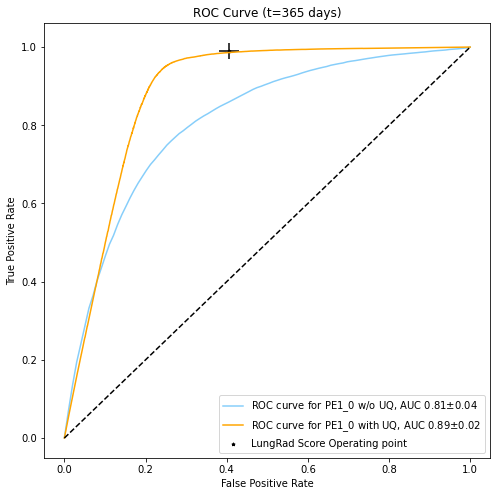

: 

In [81]:


draw_stacked_roc(auc_wo_uq_collection, auc_w_uq_collection, 
                fpr_wo_uq_collection, tpr_wo_uq_collection, 
                fpr_w_uq_collection, tpr_w_uq_collection, 
                rad_info_collection, ind, permutation_num,
                result_path, show=True, )
